# Encoder Block

Encoder Blockの全容は次の通り。

![](images/encoderblock.png)

入力データをLayer Normalizationで正規化し、さらにMHSAでデータを「より良い状態」にする。そして入力データと生成されたデータを合成する。

さらにそのデータを再度Layer Normalizationして正規化し、MLP（多重パーセプトロン）を通してデータを生成する。そのデータと2度目の正規化前の合成データを合成し、アウトプットする。

MHSAは前節で紹介した通り。
ここではLayer Normalizationを説明する。

## Layer Normalization

レイヤーの正規化。データ自身の平均と標準偏差を使う。

Batch Normalizationという正規化手法もあるが、正規化するときに使う平均と標準偏差がバッチ全体の物を使うため、データごとにトークン数が異なる場合は使えない。
Layer Normalizationは各データごとの平均と標準偏差を使うため、そういった不都合な点がない。

$a  =  \begin{pmatrix} a_1\\ a_2\\ \vdots\\ a_K  \end{pmatrix}  \in \mathbb{R}^K$ に対して（算術）平均$\mu$と$\sigma$は

$
\begin{aligned}
\mu &= \frac{1}{K} \sum_{i=1}^K a_i\\
\sigma &= \sqrt{\frac{1}{K} \sum_{i=1}^K (a_i - \mu)^2}
\end{aligned}
$

である。

また、$\beta_i, \gamma_i \in \mathbb{R}$ を$a$の$i$番目の要素 $a_i$ に対する学習パラメータとすると、 Layer Normalization $LN(a)_i$ は

$
\displaystyle LN(a)_i = \gamma_i \frac{a_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta_i \quad (i = 1, 2, \dots, K)
$

である。ただし $\epsilon$は分母が0となることを防ぐための無限小の数値とする。


具体的に見てみる。画像データをInput Layerに通して生成されたテンソルを
$
x = 
\begin{pmatrix}
[x_{1,1} & x_{1,2} & \dots & x_{1,384}]\\
[x_{2,1} & x_{2,2} & \dots & x_{2,384}]\\
[x_{3,1} & x_{3,2} & \dots & x_{3,384}]\\
[x_{4,1} & x_{4,2} & \dots & x_{4,384}]\\
[x_{5,1} & x_{5,2} & \dots & x_{5,384}]\\
\end{pmatrix}
 \in R^{N \times D}
 $
 ($5$はトークン数（パッチ数+クラストークン）、$384$は各パッチごとにベクトルの長さ)とする。$x$の1列目$p_1=[x_{1,1} \quad x_{1,2} \quad \dots \quad x_{1,384}]$に
 Layer Normalizationを適用することを考える。

具体的に見るために $p_1 = [1, 2, 1, 2, 1, 2, \dots, 1, 2]$だったとすると、平均と標準偏差は
$$
\begin{aligned}
\mu &= \frac{1}{D} (1 + 2 + 1 + 2 + 1+ 2+ \dots, 1 + 2)\\
    &= 1.5\\
\sigma &= \sqrt{\frac{1}{D} ((1 - 3/2)^2 + (2 - 3/2)^2 + (1 - 3/2)^2 + (2 - 3/2)^2 + (1 - 3/2)^2 + (2 - 3/2)^2  + \dots + (1 - 3/2)^2 + (2 - 3/2)^2 ) }\\
       &\fallingdotseq 0.25
\sigma^2 &= 0.0625
\end{aligned}
$$

であるから、

$$
\begin{aligned}
&[LN(p_1)_1, LN(p_1)_2, \dots LN(p_1)_D] \\
&= 
[
\gamma_1 \frac{1 - \frac{3}{2}}{\sqrt{(0.0625 + \epsilon)}} + \beta_1, 
\gamma_2 \frac{2 - \frac{3}{2}}{\sqrt{(0.0625 + \epsilon)}} + \beta_2, 
\dots, 
\gamma_{383} \frac{1 - \frac{3}{2}}{\sqrt{(0.0625 + \epsilon)}} + \beta_{383},
\gamma_{384} \frac{2 - \frac{3}{2}}{\sqrt{(0.0625 + \epsilon)}} + \beta_{384}
]
\end{aligned}
$$

となる。








## MLP

MLPは「MultiLayer Perceptron（多重パーセプトロン）」の略。
いわゆるディープラーニングのフローをイメージできれば良い。

ViTにおけるMLPは次のような構成で使う。

![](images/mlp.png)

ディープラーニング的図でみると次のようになる。

![](images/mlp_dl.png)

一つ目の隠れ層のニューロン数が4Dになっていることに注意。元論文に従っている。

GELUは「Gaussian Error Linear Unit(ガウス誤差線形ユニット)」という活性化関数。ReLUをふにゃっとした感じ。

/var/folders/js/lwxty0zd1kjf9lrjh2v4rvx40000gn/T/ipykernel_54351/3583834801.py:14: RuntimeWarning: invalid value encountered in sqrt
  return x / 2 * (1 + np.tanh(np.sqrt( (2 / np.pi) * (x + 0.044715 * x ** 3) )))


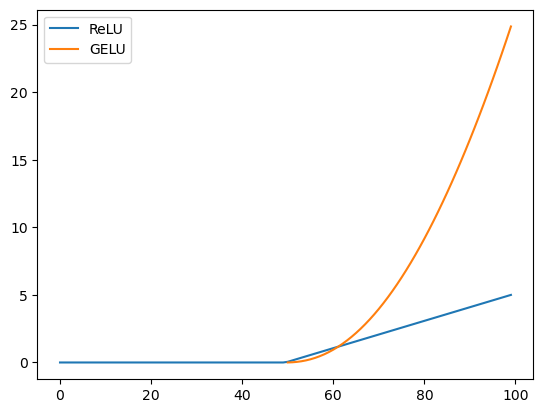

In [21]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def relu(x):
    return np.maximum(0, x)

def gelu(x):
    return x * phi(x)

def phi(x):
    return x / 2 * (1 + np.tanh(np.sqrt( (2 / np.pi) * (x + 0.044715 * x ** 3) )))

x = np.linspace(-5, 5, 100)
relu_y = relu(x)
gelu_y = gelu(x)

re = sns.lineplot(relu_y, label="ReLU")
ge = sns.lineplot(gelu_y, label="GELU")

## 数式表現

$z_0 \in \mathbb{R}^{N \times D}$ を Input Layerから入力されたデータとする。

また、Encoder BlockをL個で構成されているとするとし、$z_i(i=1,2,\dots,L)$をi番目のEncoder Blockで処理されたデータ、
すなわち$EB_i(z)$をi個めのEncoder Blockとすれば、

$z_{i+1} = EB_{i}(z)$

となる。このようにすれば、Input Layerから入力されたデータが$z_0$と表現しても違和感がない。

Encoder　Blockの処理を見ていく。

i番目のEncoder Blockを処理する場合を考える。すると処理するデータは$z_{i-1}$である。

$z_{i-1}$ の Linear Normalizationで正規化したデータは$LN(z_{i-1})$である。

次にこれをMHSAの処理をすると、$MHSA(LN(z_{i-1}))$ であり、これと$z_{i-1}$を合成して combine1 を作成する。すなわち

$combine1 = MHSA(LN(z_{i-1})) + z_{i-1}$

と表現できる。

次にこのcombine1をまたLayer NormalizationしてMLPを適用し、生成されたデータとcombine1を合成してcombine2をつくるから

$combine2 = MLP(LN(combine1)) + combine1$

と表現できる。

これらを一気に表現すると、i番目のEncoder Blockの処理 $EB_i(z)$ は

$$
\begin{aligned}
z_i &= EB_i(z_{i-1})\\
&= MLP(LN(MHSA(LN(z_{i-1})) + z_{i-1} )) + MHSA(LN(z_{i-1})) + z_{i-1} \\
&(但しi = 1, 2, \dots, L)
\end{aligned}
$$

である。


## 実装

In [25]:
import torch
import torch.nn as nn

class VitEncoderBlock(nn.Module):
    def __init__(
        self,
        emb_dim: int=384,
        head: int=8,
        hidden_dim:int=384*4,
        dropout: float = 0.
        ):
        """

        Args:
            emb_dim (int, optional): 埋め込みのベクトルの長さ. Defaults to 384.
            head (int, optional): ヘッド数. Defaults to 8.
            hidden_dim (int, optional): 隠れ層のニューロンの数. Defaults to 384*4.
            dropout (float, optional): ドロップアウト率. Defaults to 0..
        """
        self.ln1 = nn.LayerNorm(emb_dim)
        self.mhsa = MultiHeadSelfAttention(emb_dim=emb_dim, head=head, dropout=dropout)

        self.ln2 = nn.LayerNorm(emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, emb_dim),
            nn.Dropout(dropout)
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """

        Args:
            z (torch.Tensor): Encoder Blockの入力。(B, N, D)
                B: バッチ数
                N: パッチ数
                D: 埋め込みベクトルの長さ

        Returns:
            torch.Tensor: EncoderBlockの出力。(B, N, D)
                B: バッチ数
                N: パッチ数
                D: 埋め込みベクトルの長さ

        """
        
        # 1回目のLayer Normalization+MHSAをした結果とzを合成
        combine1 = self.mhsa(self.ln1(z)) + z

        # combine1に2回目のLayer NormalizationとMSAをして、combine1と合成
        out = self.mlp(self.ln2(combine1)) + combine1

        return out

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadSelfAttention(nn.Module):
    def __init__(
        self,
        emb_dim: int = 384,
        head: int = 3,
        dropout: float = 0
    ):
        """

        Args:
            emb_dim (int, optional): Input Layerから出てくるベクトルの次元. Defaults to 384.
            head (int, optional): ヘッドの数. Defaults to 3.
            dropout (float, optional): ドロップアウト数. Defaults to 0.
        """
        super().__init__()
 
        self.emb_dim = emb_dim
        self.head = head
        self.head_dim = emb_dim // head
        self.sqrt_dh = self.head_dim ** 0.5 # softmax関数の時に使う
    
        # q,k,vの線形層
        self.w_q = nn.Linear(emb_dim, emb_dim, bias=False)
        self.w_k = nn.Linear(emb_dim, emb_dim, bias=False)
        self.w_v = nn.Linear(emb_dim, emb_dim, bias=False)

        # 正規化するときにDropoutをする
        self.attn_drop = nn.Dropout(dropout)

        # MHSAの結果を出力に埋め込むための線形層
        self.w_o = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.Dropout(dropout)
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """

        Args:
            z (torch.Tensor): MHSAの入力。(B, N, D)
                B: バッチ数
                N: トークン数
                D: ベクトルの次元
            

        Returns:
            torch.Tensor: MHSAの出力。(B, N, D)
                B: バッチ数
                N: トークン数
                D: ベクトルの次元
        """
        
        batch_num, patch_num, _ = z.size()

        # 埋め込み
        ## (B, N, D) -> (B, N, D)
        q = self.w_q(z)
        k = self.w_k(z)
        v = self.w_v(z)

        # ヘッドを分割
        ## h: ヘッド数
        ## (B, N, D) -> (B, N, h, D/h)
        q = q.view(batch_num, patch_num, self.head, self.head_dim)
        k = q.view(batch_num, patch_num, self.head, self.head_dim)
        v = q.view(batch_num, patch_num, self.head, self.head_dim)

        # transposeして (B, N, h, D/h) から (B, h, N, D/h) に変更する
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # qk^T を計算するために kを転地する
        k_t = k.transpose(2, 3)

        # qk^T
        # (B, h, N, D/h) x (B, h, D/h, N) -> (B, h, N, N)
        dots = (q @ k_t) / self.sqrt_dh
        
        # softmax
        attn = F.softmax(dots, dim=-1)

        # dropout
        attn = self.attn_drop(attn)

        # 加重和 softmax(qt^t/sqrt(Dh))v
        ## (B, h, N, N) x (B, h, N, D/h) -> (B, h, N, D/h)
        out = attn @ v

        # transpose
        ## (B, h, N, D/h) -> (B, N, h, D/h)
        out = out.transpose(1, 2)

        ## (B, N, h, D/h) -> (B, N, D)
        out = out.reshape(batch_num, patch_num, self.emb_dim)

        # Output
        # (B, N, D) -> (B, N, D)
        out = self.w_o(out)

        return out